# Pneumonia Classification in Chest X-rays using Transfer Learning <br> (ResNet-18)
In recent years, increasing the depth of neural networks has proven crucial for enhancing their learning capacity and performance in complex tasks, such as image recognition. However, training increasingly deep networks poses significant technical challenges, particularly related to the propagation of information and gradients during training.

Kaiming He and collaborators stated: 
>"Driven by the significance of depth, a question arises: Is learning better networks as easy as stacking more layers?" 

This question is precisely what ResNet addresses, a convolutional neural network (CNN) architecture whose name indicates the number of layers in the architecture. Introduced in 2015 by Microsoft, ResNet offered a solution to the vanishing gradient problem that occurred when adding extra layers, through the use of **skip connections**. The ResNet family includes models of various depths, such as ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, each adapted to different levels of complexity and learning capacity.

You can find more details in the original [ResNet paper](https://arxiv.org/abs/1512.03385)

### 1. Library Imports for Transfer Learning

For the implementation of the second model, the core PyTorch libraries were utilized. Specifically, the models sub-module from torchvision was imported to access the ResNet18 architecture and its pre-trained weights. Additionally, seaborn was included to enhance the visualization of the final comparison metrics.

In [26]:
# Core deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models 

# Data handling and preprocessing
import numpy as np
from torchvision import transforms

# Visualization and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# System and environment configuration
import os
# Disable MacOS malloc stack logging to avoid memory warnings on Apple Silicon
os.environ["MallocStackLogging"] = "0"

import sys
sys.path.append(os.path.abspath(os.path.join("..")))
from src.data.dataloaders import get_loaders
import seaborn as sns

# Aesthetic settings for high-quality plots
plt.style.use("seaborn-v0_8-muted")
plt.rcParams["figure.figsize"] = (12, 6)


### 2. Data Loading and Preprocessing

The system paths were configured to access local modules and the dataloaders were initialized. 
- An image size of 228x228 was selected to balance detail and computational cost.
- A batch size of 32 was selected as a balance between convergence stability and computational efficiency.”

In [21]:
"""
Data loaders are initialized using a preprocessing pipeline
specifically adapted for ResNet architectures, including
ImageNet normalization and conservative data augmentation.
"""

train_loader, test_loader = get_loaders(
    batch_size=32,
    model_type="resnet"
)

assert train_loader is not None and test_loader is not None


Apple Silicon detected. Setting num_workers to 0 for compatibility.


### 3. ResNet18 Implementation and Customization

The ResNet18 architecture was adapted to serve as the primary model. Since the original model was trained on the ImageNet dataset (RGB images), the input layer was modified to process single-channel grayscale X-rays. Furthermore, the weights of the convolutional base were frozen to prevent their distortion during the initial training phase.

In [22]:
# Create a ResNet18 model using transfer learning
def create_resnet_model(num_classes=2, dropout=0.5):
    """
    Create a pre-trained ResNet18 model with a custom classifier.
    """
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    
    # Stage 1: Freeze all convolutional layers.
    for param in model.parameters():
        param.requires_grad = False

    # Replace final classifier.
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, num_classes)
    )
    
    return model

# Device Selection.
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on: CPU")

model = create_resnet_model(dropout=0.5).to(device)
print("The ResNet18 model was created and migrated to the device.")

Training on: Apple Silicon GPU (MPS)
The ResNet18 model was created and migrated to the device.


### 4. Training Loop Definition

A function was created to manage the training process, error calculation, and weight optimization.

In [23]:

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=3):

    """
    Training loop with early stopping, where the test set is used
    as a validation proxy due to dataset constraints.
    """
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    # Initialization for early stopping.
    best_loss = float("inf")
    epochs_no_improve = 0


    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
            
        print(f"\n--- Epoch {epoch+1}/{epochs} ---")
            
        for images, labels in train_loader:
                # Data was moved to the selected device (MPS/CUDA/CPU).
            images, labels = images.to(device), labels.to(device)
                
             # Gradients were reset
            optimizer.zero_grad()
                
            # Forward pass: Predictions were generated.
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            # Backward pass: Gradients were calculated and weights updated.
            loss.backward()
            optimizer.step()
                
            # Training metrics were accumulated.
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
                
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train

        # Evaluation Phase
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
            
        # Gradient calculation was disabled for evaluation to save memory.
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                    
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
            
        val_loss = test_loss / len(test_loader)
        val_acc = 100 * correct_test / total_test
            
        # Epoch metrics were stored in history.
        history['train_loss'].append(epoch_loss)
        history['test_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['test_acc'].append(val_acc)
            
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
        print(f"Test  Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

        # Save the best model based on test loss with early stopping.
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "../models_saved/resnet_best.pth")
            print("Best model saved")
        else:
            epochs_no_improve += 1
            print(f"No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
            
    return history




### 5. Model Training Strategy: Two-Stage Transfer Learning
To achieve the best performance on our X-ray classification task, we implement a two-phase training strategy. This approach leverages the pre-trained weights of ResNet-18 while adapting them specifically to the nuances of medical imaging.

- Phase 1: Feature Extraction

In this initial stage, we freeze the backbone of the network and only train the newly added classification head (Fully Connected layer). The goal is to utilize the high-level features already learned by ResNet on ImageNet and adapt the final output to our two classes (Normal vs. Pneumonia) without distorting the pre-trained weights.

- Phase 2: Fine-Tuning

Once the classifier has stabilized, we unfreeze the entire architecture. By using a significantly lower learning rate (10 
−4
 ), we allow the weights of all layers to be slightly adjusted. This "fine-tuning" process enables the convolutional filters to specialize in the specific textures and patterns found in chest X-rays, further refining the model's accuracy.

In [ ]:
# Loss function and model initialization.

criterion = nn.CrossEntropyLoss()

# Stage 1: Feature Extraction
print("\n" + "="*50)
print("Starting phase 1: Feature Extraction")
print("="*50)

# Only the parameters of the fc layer (the classifier) are optimized.
optimizer_fe = optim.Adam(model.fc.parameters(), lr=0.001)

history_fe = train_model(
    model, train_loader, test_loader, criterion, optimizer_fe, 
    epochs=10, patience=3
)

# The best model from the previous phase is loaded before unfreezing.
print("\nLoading best model from Phase 1 to start fine-tuning...")
state_dict = torch.load(
    "../models_saved/resnet_best.pth",
    weights_only=True,
    map_location=device
)
model = create_resnet_model(num_classes=2, dropout=0.5).to(device)
model.load_state_dict(state_dict)


# Stage 2: Fine tuning.
print("\n" + "="*50)
print("Starting phase 2: Fine-tuning")
print("="*50)

# All layers are unfrozen for fine-tuning.
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Use a much lower learning rate (10× or 100× smaller)
optimizer_ft = optim.Adam(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-4
)


history_ft = train_model(
    model, train_loader, test_loader, criterion, optimizer_ft, 
    epochs=15, patience=4
)


Starting phase 1: Feature Extraction

--- Epoch 1/10 ---
Train Loss: 0.1891 | Acc: 92.48%
Test  Loss: 0.3301 | Acc: 88.78%
Best model saved

--- Epoch 2/10 ---
Train Loss: 0.1467 | Acc: 94.38%
Test  Loss: 0.4564 | Acc: 85.90%
No improvement (1/3)

--- Epoch 3/10 ---
Train Loss: 0.1415 | Acc: 94.44%
Test  Loss: 0.4876 | Acc: 83.33%
No improvement (2/3)

--- Epoch 4/10 ---
Train Loss: 0.1191 | Acc: 95.65%
Test  Loss: 0.3907 | Acc: 86.06%
No improvement (3/3)
Early stopping triggered

Loading best model from Phase 1 to start fine-tuning...

Starting phase 2: Fine-tuning

--- Epoch 1/15 ---
Train Loss: 0.1101 | Acc: 95.78%
Test  Loss: 0.2887 | Acc: 91.51%
Best model saved

--- Epoch 2/15 ---
Train Loss: 0.0751 | Acc: 97.22%
Test  Loss: 0.3331 | Acc: 89.26%
No improvement (1/4)

--- Epoch 3/15 ---
Train Loss: 0.0628 | Acc: 98.06%
Test  Loss: 0.4706 | Acc: 85.90%
No improvement (2/4)

--- Epoch 4/15 ---
Train Loss: 0.0604 | Acc: 97.89%
Test  Loss: 0.3631 | Acc: 89.10%
No improvement (3/4)



### 6. Performance Metrics and Diagnostic Validation
Evaluating a medical diagnostic model requires going beyond simple accuracy. In a clinical environment, the cost of a False Negative (failing to detect pneumonia) is significantly higher than a False Positive. Therefore, our evaluation process focuses on a comprehensive analysis of the model's decision-making process.

The evaluate_model function performs a full pass over the unseen test set, ensuring the model's generalizability. We use torch.no_grad() to disable gradient calculation, which reduces memory consumption and speeds up computation during inference. For each image, the model outputs raw scores (logits) that we transform into probabilities using the Softmax function, allowing us to quantify the confidence of each prediction.

The resulting Classification Report provides a detailed breakdown of:

Precision: The accuracy of positive predictions.

Recall (Sensitivity): The ability of the model to find all relevant cases of pneumonia.

F1-Score: The harmonic mean of precision and recall, offering a balanced view of the model's performance.

In [24]:
def evaluate_model(model, test_loader, device):
    """
    Complete evaluation on the test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    test_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    print("\n" + "="*60)
    print("Final Evaluation")
    print("="*60)
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=["NORMAL", "PNEUMONIA"]))
    
    return all_labels, all_preds, all_probs

# Load the best model and perform evaluation
state_dict = torch.load(
    "../models_saved/resnet_best.pth",
    map_location=device
)
model.load_state_dict(state_dict)


test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

/var/folders/r3/nz7bfb694cv8lfq86vxg0lfr0000gn/T/ipykernel_20261/1584502976.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(



Final Evaluation
Test Accuracy: 91.51%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.79      0.87       234
   PNEUMONIA       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



### 5. Visualization of Results

Training curves


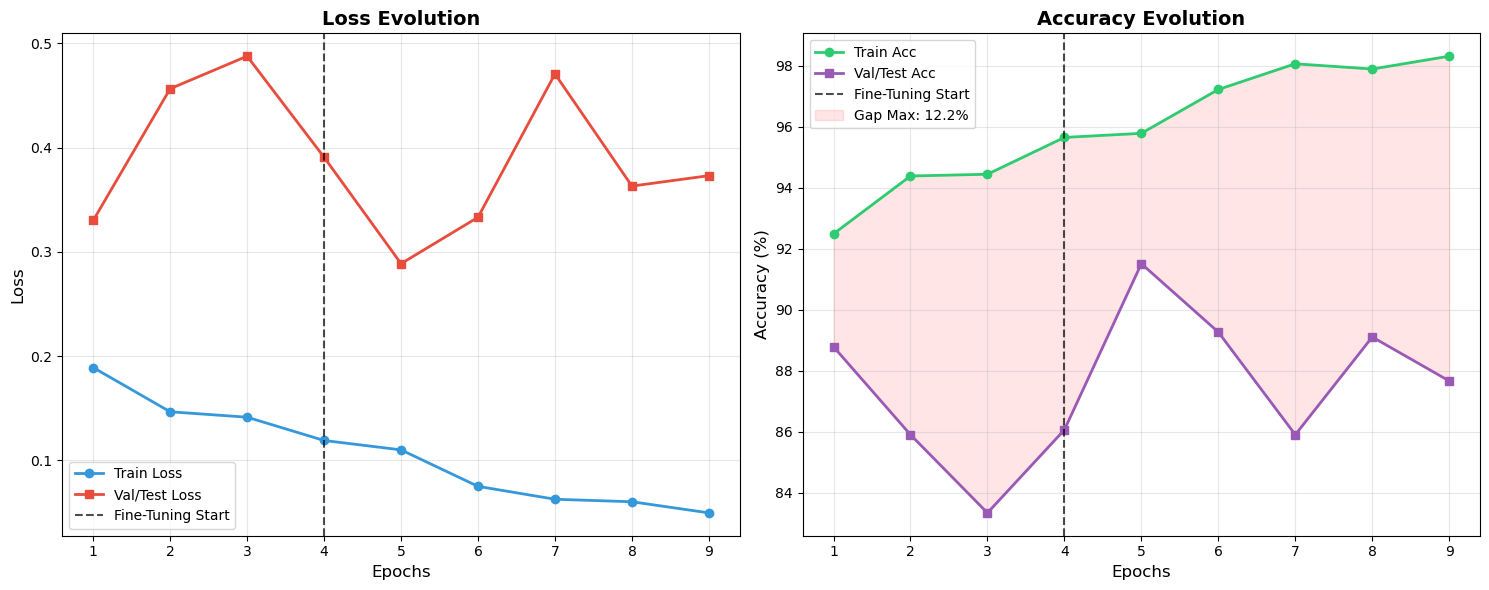

Evaluation plots


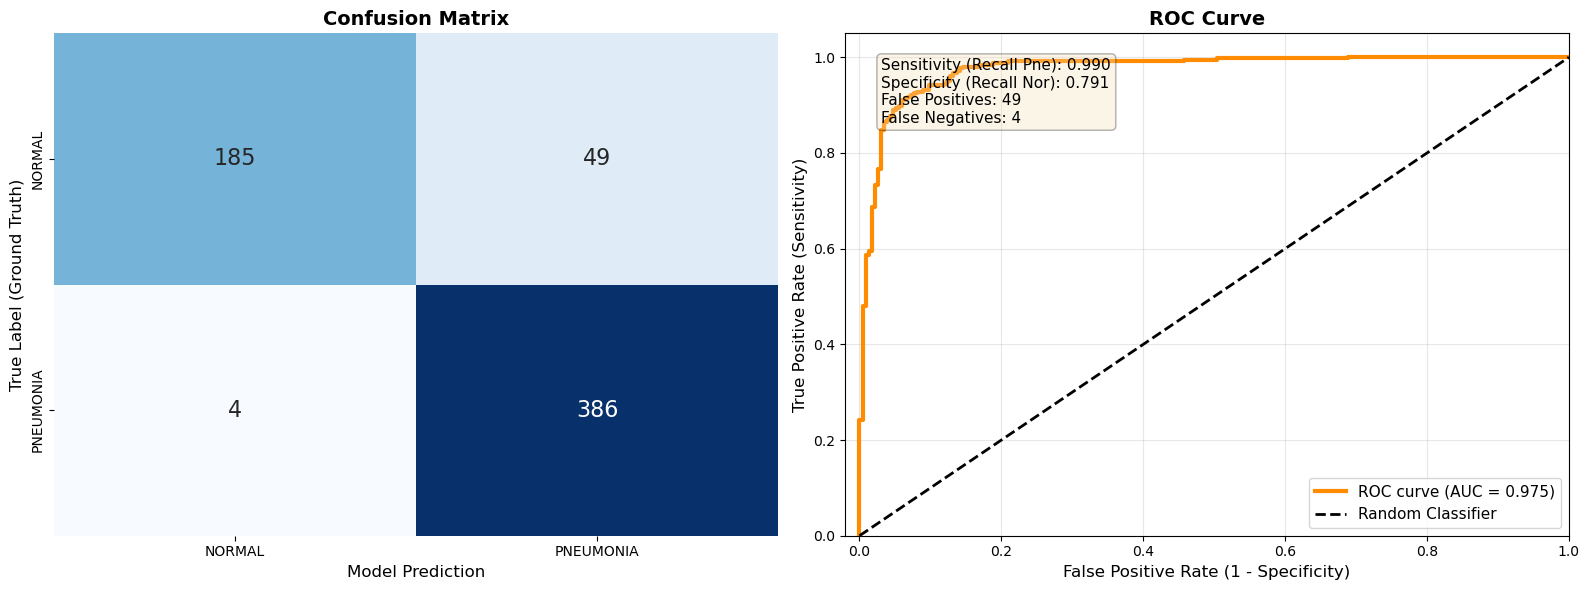


 Summary of Clinical Metrics: 
  ➢ Sensitivity: 0.9897
  ➢ Specificity: 0.7906
  ➢ AUC-ROC:     0.9750


In [27]:
# Directory setups.
# Avoids errors if the folder doesn't exist.

os.makedirs("../results/figures", exist_ok=True)

def plot_training_curves(history_p1, history_p2):

    """
    Plot training curves by combining Phase 1 (Feature Extraction) 
    and Phase 2 (Fine-Tuning).
    """

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    """
    Combine histories from both phases:
    - history_p1 = history_fe (Feature Extraction).
    - history_p2 = history_ft (Fine-Tuning).
    """
    
    epochs_p1 = len(history_p1["train_loss"])
    epochs_p2 = len(history_p2["train_loss"])
    
    # The X-axis is continuous.
    total_epochs_range = list(range(1, epochs_p1 + epochs_p2 + 1))
    
    # Concatenate lists of metrics.
    train_loss = history_p1["train_loss"] + history_p2["train_loss"]
    test_loss = history_p1["test_loss"] + history_p2["test_loss"]
    train_acc = history_p1["train_acc"] + history_p2["train_acc"]
    test_acc = history_p1["test_acc"] + history_p2["test_acc"]

    # Figure 1: Loss.
    axes[0].plot(total_epochs_range, train_loss, "o-", label="Train Loss", linewidth=2, color="#3498db")
    axes[0].plot(total_epochs_range, test_loss, "s-", label="Val/Test Loss", linewidth=2, color="#e74c3c")

    # Vertical line indicating the start of fine-tuning.
    axes[0].axvline(x=epochs_p1, color="black", linestyle="--", alpha=0.7, label="Fine-Tuning Start")

    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_title("Loss Evolution", fontsize=14, weight="bold")
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Figure 2: Accuracy.
    axes[1].plot(total_epochs_range, train_acc, "o-", label="Train Acc", linewidth=2, color="#2ecc71")
    axes[1].plot(total_epochs_range, test_acc, "s-", label="Val/Test Acc", linewidth=2, color="#9b59b6")

    # Vertical line indicating the start of Fine-Tuning.
    axes[1].axvline(x=epochs_p1, color="black", linestyle="--", alpha=0.7, label="Fine-Tuning Start")

    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Accuracy (%)", fontsize=12)
    axes[1].set_title("Accuracy Evolution", fontsize=14, weight="bold")
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # Detect and highlight the overfitting area when the gap exceeds 10%.
    max_gap = max([t - te for t, te in zip(train_acc, test_acc)])
    if max_gap > 10:
        axes[1].fill_between(total_epochs_range, train_acc, test_acc, 
                            alpha=0.1, color="red", 
                            label=f"Gap Max: {max_gap:.1f}%")
        axes[1].legend(fontsize=10)
    
    plt.tight_layout()
    # Save figure.
    plt.savefig("../results/figures/resnet_training_curves.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_confusion_matrix_and_roc(labels, preds, probs):
    """
    Generate confusion matrix and ROC curve based on test set predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Figure 3: Confusion Matrix 
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"],
                ax=axes[0], annot_kws={"size": 16}, cbar=False)

    axes[0].set_title("Confusion Matrix", fontsize=14, weight="bold")
    axes[0].set_ylabel("True Label (Ground Truth)", fontsize=12)
    axes[0].set_xlabel("Model Prediction", fontsize=12)

    # Calculate clinical metrics inside the function for visualization on the plot.
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall PNEUMONIA
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Recall NORMAL
    
    # Figure 4: ROC Curve.
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, linewidth=3, color="darkorange", label=f"ROC curve (AUC = {roc_auc:.3f})")
    axes[1].plot([0, 1], [0, 1], "k--", linewidth=2, label="Random Classifier")

    axes[1].set_xlim([-0.02, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
    axes[1].set_ylabel("True Positive Rate (Sensitivity)", fontsize=12)
    axes[1].set_title("ROC Curve", fontsize=14, weight="bold")
    axes[1].legend(loc="lower right", fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Text box displaying detailed metrics.
    stats_text = (f"Sensitivity (Recall Pne): {sensitivity:.3f}\n"
                  f"Specificity (Recall Nor): {specificity:.3f}\n"
                  f"False Positives: {fp}\n"
                  f"False Negatives: {fn}")

    props = dict(boxstyle="round", facecolor="wheat", alpha=0.3)
    axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes, fontsize=11,
                verticalalignment="top", bbox=props)

    plt.tight_layout()
    plt.savefig("../results/figures/resnet_evaluation.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Display summary in the console.
    print("\n Summary of Clinical Metrics: ")
    print(f"  ➢ Sensitivity: {sensitivity:.4f}")
    print(f"  ➢ Specificity: {specificity:.4f}")
    print(f"  ➢ AUC-ROC:     {roc_auc:.4f}")


# Ejecution.

# 1. Plot Learning Curves (Loss and Accuracy).
print("Training curves")
plot_training_curves(history_fe, history_ft)

# 2. Plot Final Evaluation (Confusion Matrix and ROC).
print("Evaluation plots")
plot_confusion_matrix_and_roc(test_labels, test_preds, test_probs)
